<a href="https://colab.research.google.com/github/anurag-3-nair/Neural-Networks/blob/main/Problem_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE):
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of k_train_dev: torch.Size([1000, 36, 36, 1])
The shape of T_train_dev: torch.Size([1000, 36, 36, 1])
The shape of k_test_dev: torch.Size([200, 36, 36, 1])
The shape of T_test_dev: torch.Size([200, 36, 36, 1])
The shape of X_dev: torch.Size([1000, 36, 36, 1])
The shape of Y_dev: torch.Size([1000, 36, 36, 1])
Shape of Input_Tensor:  torch.Size([1000, 36, 36, 3])


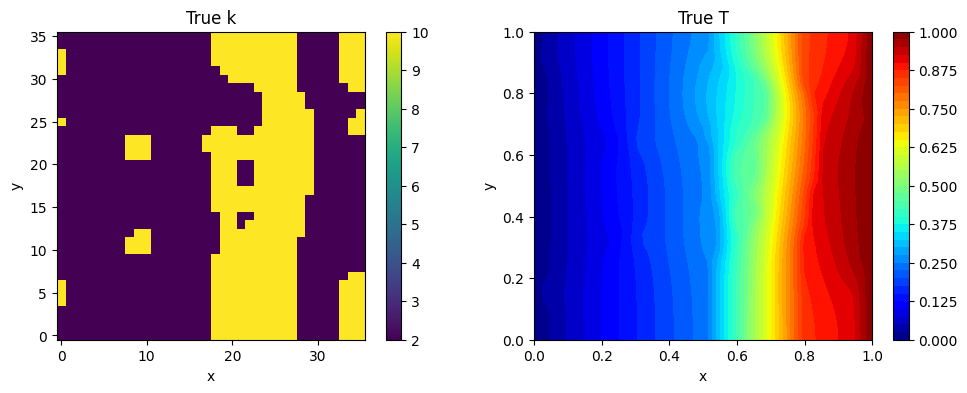

In [ ]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.interpolate import griddata
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
######################################
# Load training data
######################################
with h5py.File('/content/drive/MyDrive/DPL4PDE_Project/EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)

    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)


# print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
# print('The shape of k_train:', k_train.shape)
# print('The shape of T_train:', T_train.shape)
# print('The shape of k_test:', k_test.shape)
# print('The shape of T_test:', T_test.shape)

k_train_dev = k_train.unsqueeze(-1).repeat(1, 1, 1, 1)
print('The shape of k_train_dev:', k_train_dev.shape)

T_train_dev = T_train.unsqueeze(-1).repeat(1, 1, 1, 1)
print('The shape of T_train_dev:', T_train_dev.shape)

k_test_dev = k_test.unsqueeze(-1).repeat(1, 1, 1, 1)
print('The shape of k_test_dev:', k_test_dev.shape)

T_test_dev = T_test.unsqueeze(-1).repeat(1, 1, 1, 1)
print('The shape of T_test_dev:', T_test_dev.shape)

X_dev = X.unsqueeze(0).repeat(k_train.shape[0], 1, 1)
X_dev = X_dev.unsqueeze(-1)
print('The shape of X_dev:', X_dev.shape)

Y_dev = Y.unsqueeze(0).repeat(k_train.shape[0], 1, 1)
Y_dev = Y_dev.unsqueeze(-1)
print('The shape of Y_dev:', Y_dev.shape)

Input_tensor = torch.cat([k_train_dev, X_dev, Y_dev], dim = -1)
print('Shape of Input_Tensor: ', Input_tensor.shape)

####### Visualize the training data
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

# Fourier Network Operators (FNOs)

The FNO architecture is shown below. Applying ReLU activation.

In [ ]:
## Predicting temperature field given a 2-phase material k(x,y) with a 2D FNO

# Convolution in frequency domain
class SpectralConv2D(nn.Module):

    # Fourier layer transformation
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2D, self).__init__()

        '''2D Fourier layer: FFT -> linear transform -> Inverse FFT
        '''
        self.in_size = in_size
        self.out_size = out_size

        # Fourier modes
        self.modes1 = modes1
        self.modes2 = modes2

        #
        self.scale = 1./(in_size * out_size)
        #

        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64
        elif (dtype==torch.float64):
            ctype = torch.complex128
        else:
            raise TypeError(f'No such data type.')

        # Weights below
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2,
                                                            dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2,
                                                            dtype=ctype))
    # Complex multiplication with Einstein summation notation
    def compl_mul_2d(self, input, weights):
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    # Forward pass
    def forward(self, x):
        '''
        Input:
            x: size(batch_size, in_size, my_size, mx_size)
        Return:
            x: size(batch_size, out_size, my_size, mx_size)
        '''
        batch_size = x.shape[0]
        ####################### Compute Fourier coefficients up to factor of e^{-c}
        # size(batch_size, in_size, mx_size, my_size//2+1)
        x_ft = torch.fft.rfft2(x)

        ######################## Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

        ######################### Return to physical space
        # size(batch_size, out_size, mx_size, my_size)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        return x

class TempFNO2D(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int,
                 hidden_list:list[int], dtype=None):

        super(TempFNO2D, self).__init__()
        self.hidden_list = hidden_list

        # Activation
        self.activation = nn.ReLU()
        # Input layer
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]

        for hidden in hidden_list:
          conv_net.append(SpectralConv2D(self.hidden_in, hidden, modes1, modes2, dtype))
          w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
          self.hidden_in = hidden
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)

        # Output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)

    def forward(self, kx):
        '''
        Input:
            Input_tensor: size(batch_size, my_size, mx_size, a_size+x_size)
        Output:
            T_: size(batch_size, my_size, mx_size, out_size)
        '''
        batch_size = kx.shape[0]
        spatial_size, temporal_size = kx.shape[1], kx.shape[2]

        # The input layer:
        kx = self.fc_in(kx)
        kx = kx.permute(0, 3, 1, 2)

        # The spectral conv layers
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            kx1 = conv(kx)
            kx2 = weight(kx.view(batch_size, kx.shape[1], -1)).view(batch_size, -1, spatial_size, temporal_size)
            kx = self.activation(kx1 + kx2)

        # The output layer:
        kx = kx.permute(0, 2, 3, 1)
        kx = self.fc_out0(kx)
        kx = self.activation(kx)

        return self.fc_out1(kx)

mode1, mode2 = 8, 8
hidden_list = [48, 48, 48]
model_u = TempFNO2D(in_size=Input_tensor.shape[-1], out_size=1, modes1=mode1, modes2=mode2, hidden_list=hidden_list).to(device)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

898,385 training parameters.


# Loss function
$$
\theta^* = \arg\min_{\theta} \, L(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \left\| \mathcal{G}_\theta(a^{(i)}(\Xi)) - u^{(i)}(\Xi) \right\|^2
$$

In [ ]:
class TempFNOLoss(object):

    def __init__(self, T_model):
        self.device = device
        self.T_model = T_model

    def loss_data(self, kx_batch, T_batch):
        '''loss term'''
        batch_size = T_batch.shape[0]
        kx, T = kx_batch.to(self.device), T_batch.to(self.device)

        #
        T_pred = self.T_model(kx)
        loss = torch.norm(T.reshape(batch_size, -1)-T_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)

        return loss

# Training the model
## Defining the dataloader function
Below is the code that will load the data and section it into a custom dataset.

In [ ]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset
class MyDataset(Dataset):

    def __init__(self, kx:torch.tensor, T:torch.tensor):
        '''
        Input:
            kx: size(batch_size, a_size+x_size)
            T: size(batch_size, u_size)
        '''
        self.kx = kx
        self.T = T

    def __getitem__(self, index):
        return self.kx[index], self.T[index]

    def __len__(self):
        return self.kx.shape[0]

##############
train_loader = DataLoader(MyDataset(Input_tensor, T_train_dev), batch_size=50, shuffle=True)
for k_batch, T_batch in train_loader:
    print('kx_batch shape:', k_batch.shape, 'T_batch shape:', T_batch.shape)

kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3])

# Training the model

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import trange
import time

# Training setup
epochs = 2000
lr = 1e-3

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_u.to(device)

# Optimiser and scheduler
optimiser = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=np.int32(epochs/4), gamma=0.5)

# Error tracking (list)
train_losses = []

loss_model = TempFNOLoss(model_u)

#### Training loop
### Training procedure
t0 = time.time()
for epoch in trange(epochs):
    model_u.train()
    loss = 0.
    for k_batch, T_batch in train_loader:
        k_batch = k_batch.to(device)
        T_batch = T_batch.to(device)

        # Calculate losses
        loss_train = loss_model.loss_data(k_batch, T_batch)

        # Backpropagation
        optimiser.zero_grad()
        output = model_u(k_batch)
        loss_train.backward()
        optimiser.step()
        loss += loss_train.item()

    scheduler.step()  # Adjust learning rate
    train_losses.append(loss / len(train_loader))

    if (epoch + 1) % 100 == 0:
        print(f'Epoch:{epoch}, The loss is:{loss}')
print('The consuming time is:', time.time() - t0)

  5%|▍         | 96/2000 [38:26<12:42:29, 24.03s/it]


KeyboardInterrupt: 

In [ ]:
######################################
# Load testing data
######################################

with h5py.File('/content/drive/MyDrive/DPL4PDE_Project/EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)

    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)

k_test_dev = k_test.unsqueeze(-1).repeat(1, 1, 1, 1)
print('The shape of k_test_dev:', k_test_dev.shape)

T_test_dev = T_test.unsqueeze(-1).repeat(1, 1, 1, 1)
print('The shape of T_test_dev:', T_test_dev.shape)

X_dev = X.unsqueeze(0).repeat(k_test.shape[0], 1, 1)
X_dev = X_dev.unsqueeze(-1)
print('The shape of X_dev:', X_dev.shape)

Y_dev = Y.unsqueeze(0).repeat(k_test.shape[0], 1, 1)
Y_dev = Y_dev.unsqueeze(-1)
print('The shape of Y_dev:', Y_dev.shape)

test_input = torch.cat([k_test_dev, X_dev, Y_dev], dim = -1)
print('Shape of test_input: ', test_input.shape)

# Model prediction
model_u.eval()
with torch.no_grad():
    T_test_pred = model_u(test_input).cpu()

#######################################
# The L2 relative error
#######################################
def L2_error(T, T_pred, ndata=200):
    ''' '''
    l2 = torch.norm(T.reshape(ndata,-1)-T_pred.reshape(ndata,-1), 2, 1) / torch.norm(T.reshape(ndata, -1), 2, 1)
    return l2

#######################################
# Predicting T and computing L2 error
#######################################
T_test_pred = model_u(T_test.to(device)).detach().cpu()
print('The shape of T_pred:', T_test_pred.shape)

l2_err = L2_error(T_test, T_test_pred)
print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))

plt.figure(figsize=(8, 4))
plt.plot(l2_err.numpy(), marker='o')
plt.xlabel("Test sample index")
plt.ylabel("L2 relative error")
plt.title("L2 Relative Error on Testing Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()

#######################################
# Visualize the prediction and truth u
#######################################
T_true, T_pred = T_test[0], T_test_pred[0]

#
mesh = np.meshgrid(np.linspace(0, 1, X), np.linspace(0, 1, Y))
x_plot, y_plot = mesh[0], mesh[1]
points = np.stack((x_plot.ravel(), y_plot.ravel()), axis=-1)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# True plots
z_plot = griddata(points, np.ravel(T_true), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True Temperature Field')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata(points, np.ravel(T_pred), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Predicted Temperature Field')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata(points, np.ravel(np.abs(T_true-T_pred)), (x_plot, y_plot), method='cubic')
cntr2 = axs.flat[:][2].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()